In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import scipy.io.wavfile
import copy

---
Crash course Fourier transform
---
Switch from Time domain to frequency domain (the 2 represnet the same thing) with fourier transform (also called forward ft).

Switch to frequency domain to time domain with inverse fourier transform.


You can define a cyclig signal by its frequencies and amplitude:

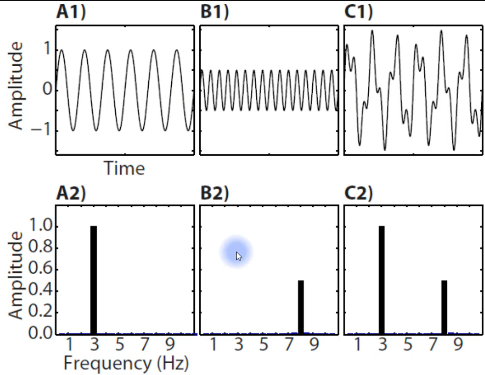

Another example more complicated signal+ noise:

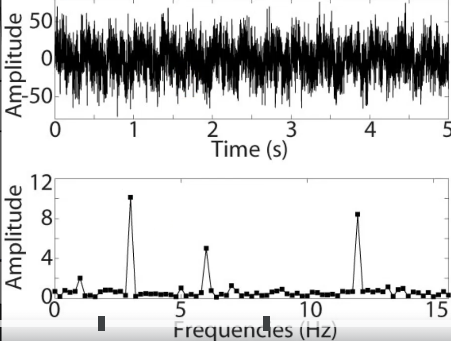

INTUITION:

You compute similarity between the white signal and a red frequency-signal with a dot product. You repeat that for manny frequencies, the result are called fourier coeficients. This gives you a spectrum that is modified a little to get to the final fourier transform.

In the inverse ft, the fourier coeficient create signals that are just added together to recreate the original signal.

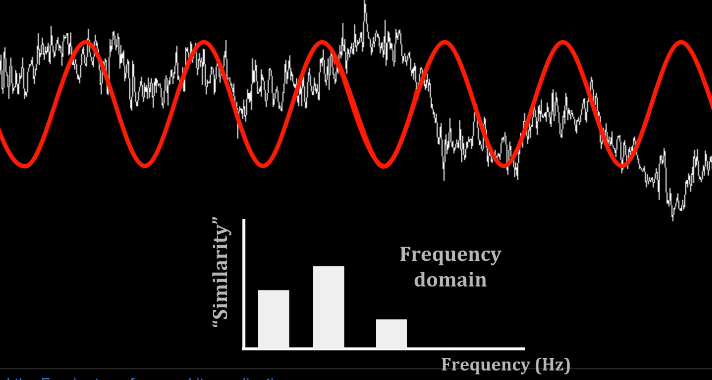

Usage:

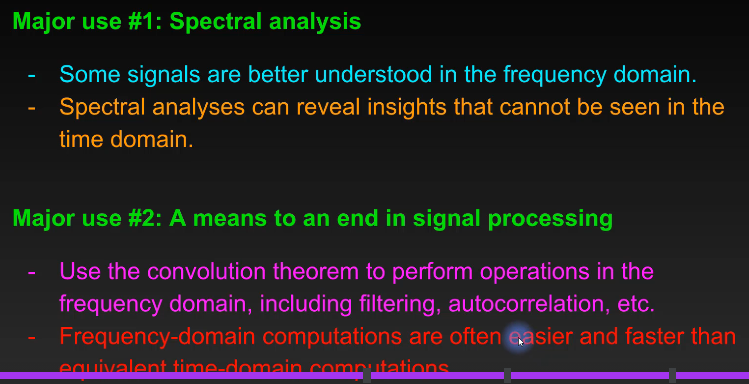

Important parameter:
Nyquist is half the sampling rate. And the number on frequencies in the ft spectrum represent the number of data point in your signal. See 2 images below for 2 spectrum of 2 signal with same sampling rate, but second signal is longer

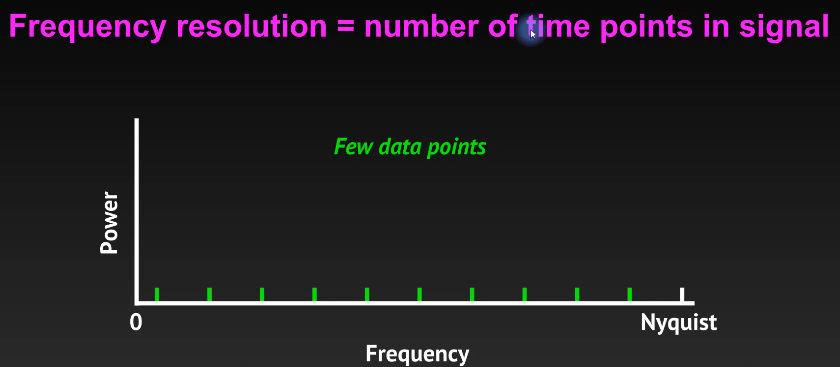
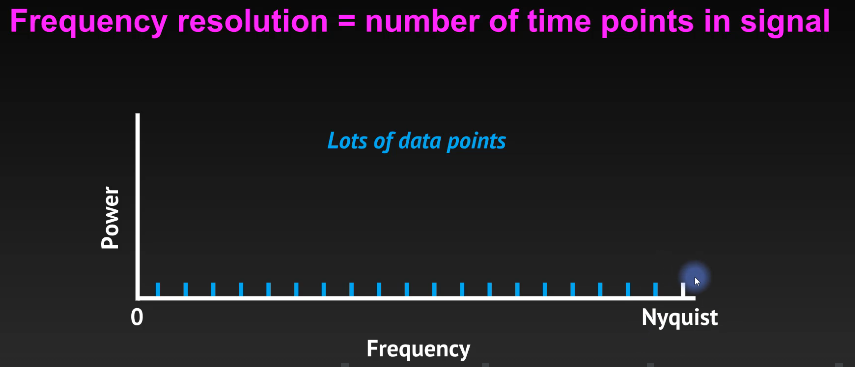

So to increase the ft spectrum resolution you need a longer signal. But also just zero padding have the same effect!!!!


---
VIDEO: Fourier transform for spectral analyses
---


In [6]:
## Generate a multispectral noisy signal

# simulation parameters
srate = 1234 # in Hz
npnts = srate*2 # 2 seconds
time  = np.arange(0,npnts)/srate

# frequencies to include
frex  = [ 12,18,30 ]

signal = np.zeros(len(time))

# loop over frequencies to create signal
for fi in range(0,len(frex)):
    signal = signal + (fi+1)*np.sin(2*np.pi*frex[fi]*time)

# add some noise
signal = signal + np.random.randn(len(signal))

# amplitude spectrum via Fourier transform
signalX = scipy.fftpack.fft(signal)
signalAmp = 2*np.abs(signalX)/npnts

# vector of frequencies in Hz
hz = np.linspace(0, srate/2, int(np.floor(npnts/2)+1))


In [32]:
print(len(hz), len(signalAmp))

1235 2468


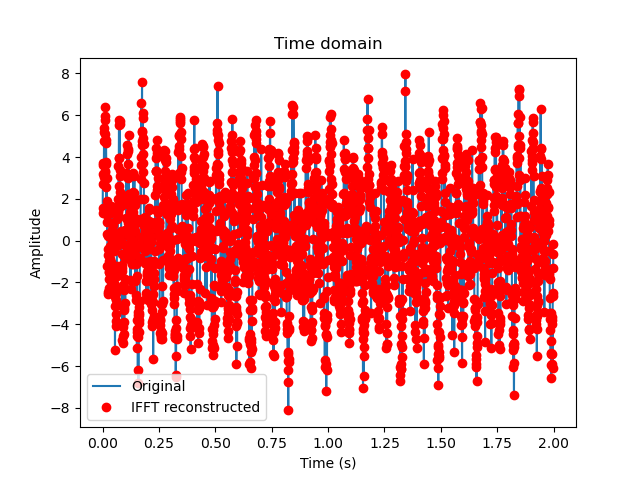

In [33]:
%matplotlib widget
## plots

plt.plot(time,signal,label='Original')
plt.plot(time,np.real(scipy.fftpack.ifft(signalX)),'ro',label='IFFT reconstructed')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time domain')
plt.legend()
plt.show()



C:\Users\fabrice.lacout\AppData\Local\Temp\ipykernel_22904\3251859303.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(hz,signalAmp[0:len(hz)],'k')


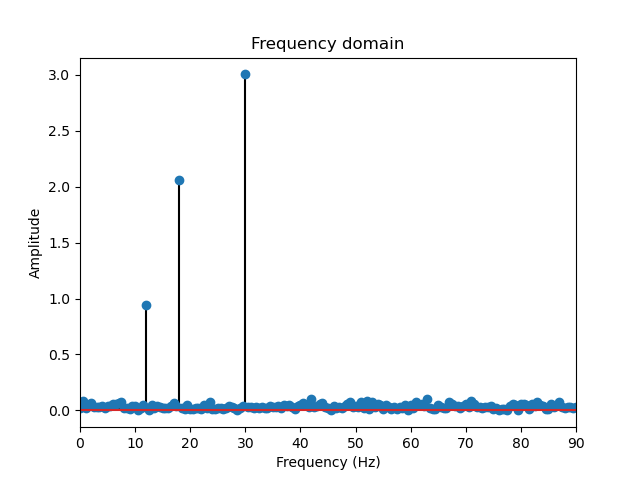

In [34]:
%matplotlib widget
plt.stem(hz,signalAmp[0:len(hz)],'k')
plt.xlim([0,np.max(frex)*3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain')
plt.show()

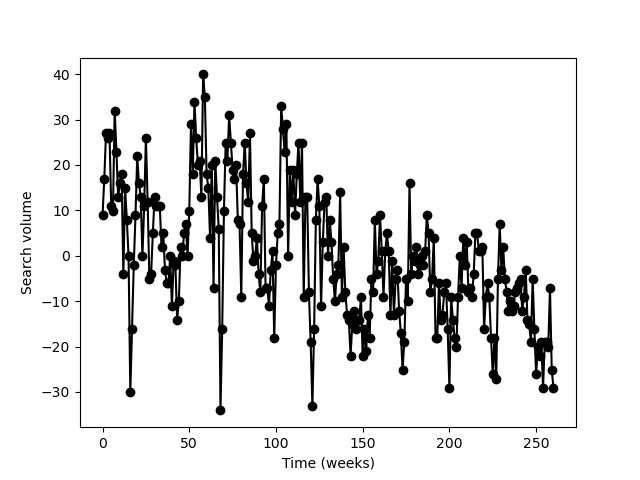

In [8]:
%matplotlib widget
## example with real data

# data downloaded from https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=signal%20processing
searchdata = [69,77,87,86,87,71,70,92,83,73,76,78,56,75,68,60,30,44,58,69,82,76,73,60,71,86,72,55,56,65,73,71,71,71,62,65,57,54,54,60,49,59,58,46,50,62,60,65,67,60,70,89,78,94,86,80,81,73,100,95,78,75,64,80,53,81,73,66,26,44,70,85,81,91,85,79,77,80,68,67,51,78,85,76,72,87,65,59,60,64,56,52,71,77,53,53,49,57,61,42,58,65,67,93,88,83,89,60,79,72,79,69,78,85,72,85,51,73,73,52,41,27,44,68,77,71,49,63,72,73,60,68,63,55,50,56,58,74,51,62,52,47,46,38,45,48,44,46,46,51,38,44,39,47,42,55,52,68,56,59,69,61,51,61,65,61,47,59,47,55,57,48,43,35,41,55,50,76,56,60,59,62,56,58,60,58,61,69,65,52,55,64,42,42,54,46,47,52,54,44,31,51,46,42,40,51,60,53,64,58,63,52,53,51,56,65,65,61,61,62,44,51,54,51,42,34,42,33,55,67,57,62,55,52,48,50,48,49,52,53,54,55,48,51,57,46,45,41,55,44,34,40,38,41,31,41,41,40,53,35,31]
N = len(searchdata)

# possible normalizations...
searchdata = searchdata - np.mean(searchdata)

# power
searchpow = np.abs( scipy.fftpack.fft( searchdata )/N )**2
hz = np.linspace(0,52,N)

plt.plot(searchdata,'ko-')
plt.xlabel('Time (weeks)')
plt.ylabel('Search volume')
plt.show()



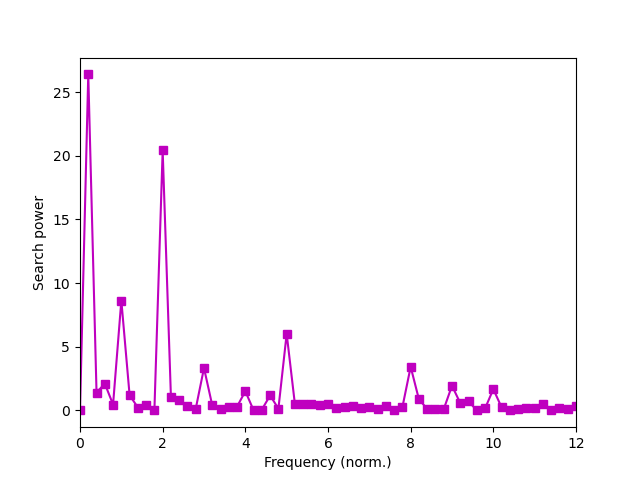

In [9]:
%matplotlib widget
plt.plot(hz,searchpow,'ms-')
plt.xlabel('Frequency (norm.)')
plt.ylabel('Search power')
plt.xlim([0,12])
plt.show()


---
# VIDEO: Welch's method
---

Applicable to signal that evolve over time.
It is meant to increase the signal to noise ratio of the fft spectrum

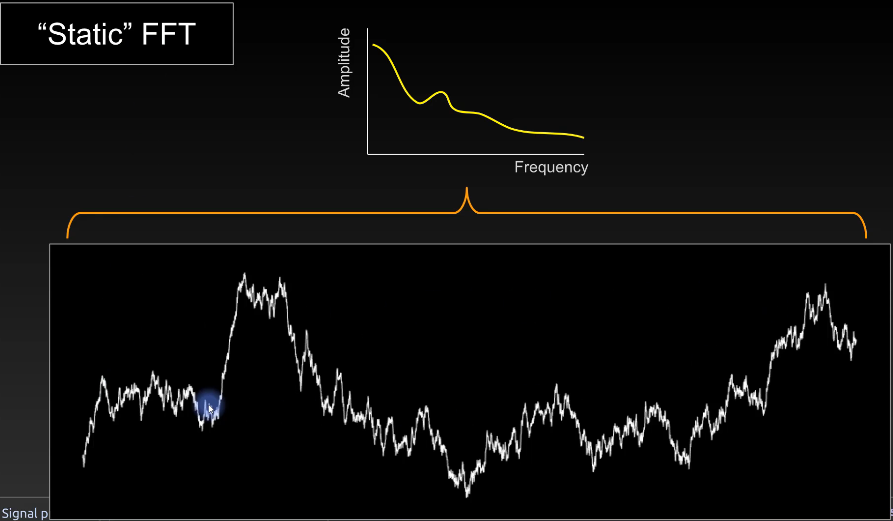

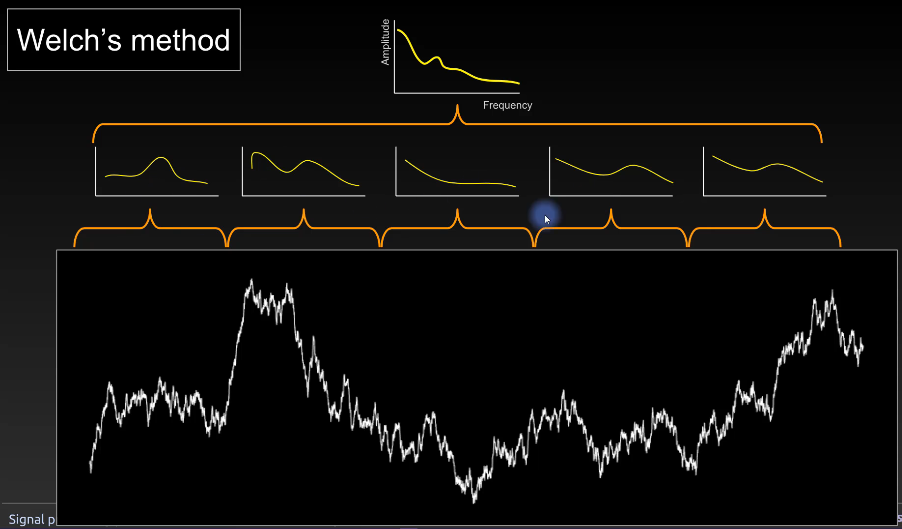

Welch method cut the signal into tiles, calculate FFT for each tiles then average the results


[1024]


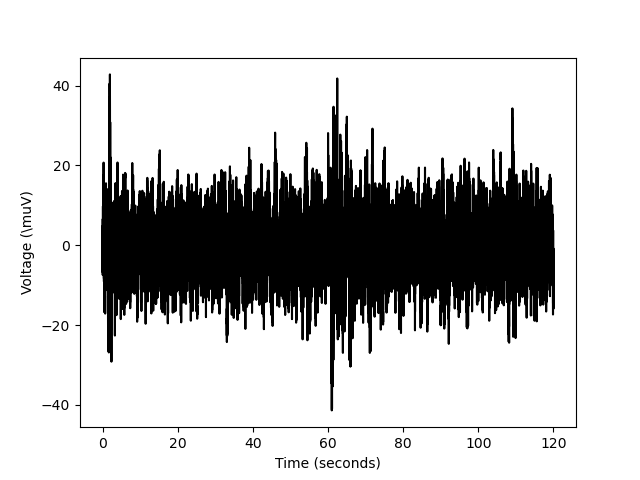

In [11]:
%matplotlib widget
# load data and extract
matdat  = sio.loadmat('EEGrestingState.mat')
eegdata = matdat['eegdata'][0]
srate   = matdat['srate'][0]
print(srate)

# time vector
N = len(eegdata)
timevec = np.arange(0,N)/srate

# plot the data
plt.plot(timevec,eegdata,'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (\muV)')
plt.show()

In [12]:
## one big FFT (not Welch's method)

# "static" FFT over entire period, for comparison with Welch
eegpow = np.abs( scipy.fftpack.fft(eegdata)/N )**2
hz = np.linspace(0,srate/2,int(np.floor(N/2)+1))


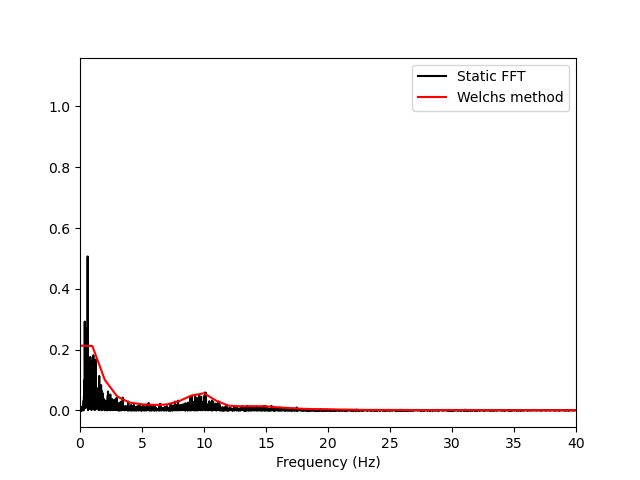

In [14]:
%matplotlib widget
## "manual" Welch's method

# window length in seconds*srate
winlength = int( 1*srate )

# number of points of overlap
nOverlap = np.round(srate/2)

# window onset times
winonsets = np.arange(0,int(N-winlength),int(winlength-nOverlap))

# note: different-length signal needs a different-length Hz vector
hzW = np.linspace(0,srate/2,int(np.floor(winlength/2)+1))

# Hann window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,int(winlength)))/2

# initialize the power matrix (windows x frequencies)
eegpowW = np.zeros(len(hzW))

# loop over frequencies
for wi in range(0,len(winonsets)):
    
    # get a chunk of data from this time window
    datachunk = eegdata[ winonsets[wi]:winonsets[wi]+winlength ]
    
    # apply Hann taper to data (TO AVOID EDGE EFFECTS)
    datachunk = datachunk * hannw
    
    # compute its power
    tmppow = np.abs(scipy.fftpack.fft(datachunk)/winlength)**2
    
    # enter into matrix
    eegpowW = eegpowW  + tmppow[0:len(hzW)]

# divide by N
eegpowW = eegpowW / len(winonsets)


# plotting
plt.plot(hz,eegpow[0:len(hz)],'k',label='Static FFT')
plt.plot(hzW,eegpowW/10,'r',label='Welch''s method')
plt.xlim([0,40])
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()
# There is less noise in the welch method.

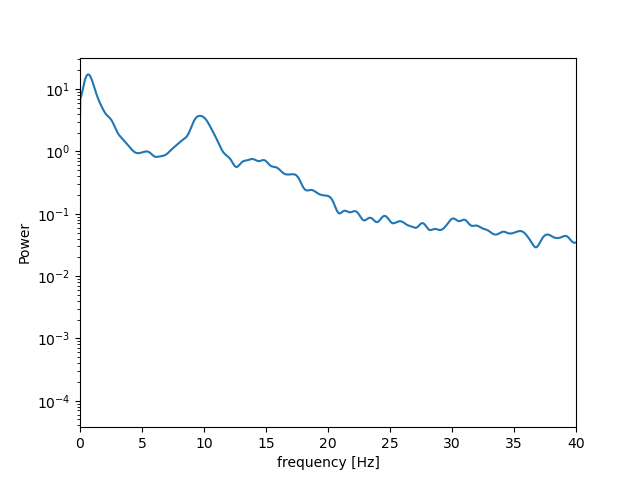

In [17]:
%matplotlib widget
## Python's welch

# create Hann window
winsize = int( 2*srate ) # 2-second window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

# number of FFT points (frequency resolution)
nfft = srate*100

f, welchpow = scipy.signal.welch(eegdata,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)

plt.semilogy(f,welchpow)
plt.xlim([0,40])
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.show()


---
# VIDEO: Spectrogram of birdsong
---


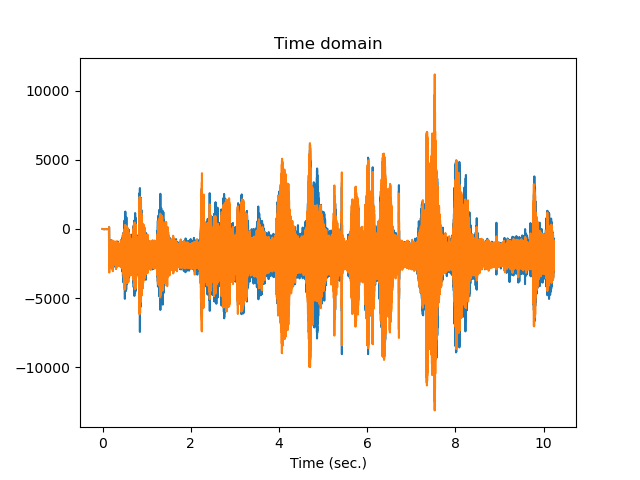

In [31]:
%matplotlib widget
## load in birdcall (source: https://www.xeno-canto.org/403881)

fs,bc = scipy.io.wavfile.read('XC403881.wav') # frequency , y values of 2 channel audio


# create a time vector based on the data sampling rate
n = len(bc)
timevec = np.arange(0,n)/fs

# plot the data from the two channels
plt.plot(timevec,bc)
plt.xlabel('Time (sec.)')
plt.title('Time domain')
plt.show()


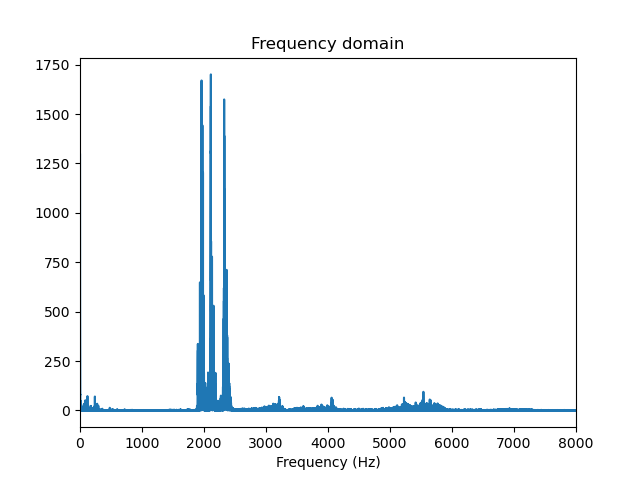

In [32]:
%matplotlib widget
# compute the power spectrum
hz = np.linspace(0, fs/2, int(np.floor(n/2)+1))
bcpow = np.abs(scipy.fftpack.fft( scipy.signal.detrend(bc[:,0]) )/n)**2
#bcpow = np.abs(scipy.fftpack.fft( bc[:,0]-np.mean(bc[:,0]) )/n)**2

# now plot it
plt.plot(hz,bcpow[0:len(hz)])
plt.xlabel('Frequency (Hz)')
plt.title('Frequency domain')
plt.xlim([0,8000])
plt.show()

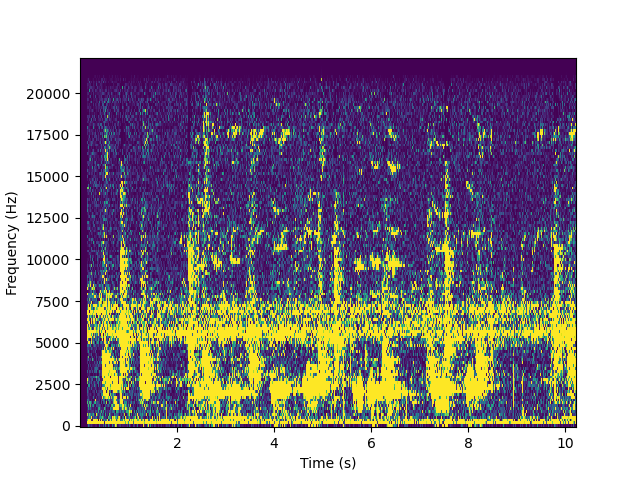

In [33]:
%matplotlib widget
## time-frequency analysis via spectrogram

frex,time,pwr = scipy.signal.spectrogram(bc[:,0],fs)

plt.pcolormesh(time,frex,pwr,vmin=0,vmax=9)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()

In [36]:
time.shape

(2012,)

In [37]:
frex.shape

(129,)

In [39]:
pwr.shape

(129, 2012)

Spectromgram ally both time domain and frequency domain into one map plot

# Code challenge

cut 0.5 s windows non overlapping

put separate windows spectrum into a matrix

plot the matrix

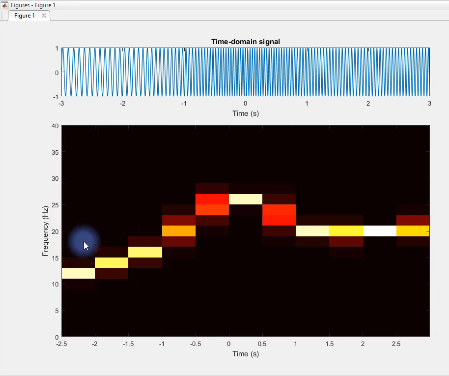

In [89]:
matdat  = sio.loadmat('spectral_codeChallenge.mat')
time = matdat['time'][0]
signal = matdat['signal'][0]
srate = matdat['srate'][0]
n = len(signal)

print(srate, n)
print(signal.shape)
print(time.shape)

[1000] 6001
(6001,)
(6001,)


In [90]:
matdat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Sep 02 19:33:06 2018',
 '__version__': '1.0',
 '__globals__': [],
 'signal': array([[ 0.06279826,  0.13159016,  0.19976369, ..., -0.94536539,
         -0.98003905, -0.99767638]]),
 'srate': array([[1000]], dtype=uint16),
 'time': array([[-3.   , -2.999, -2.998, ...,  2.998,  2.999,  3.   ]])}

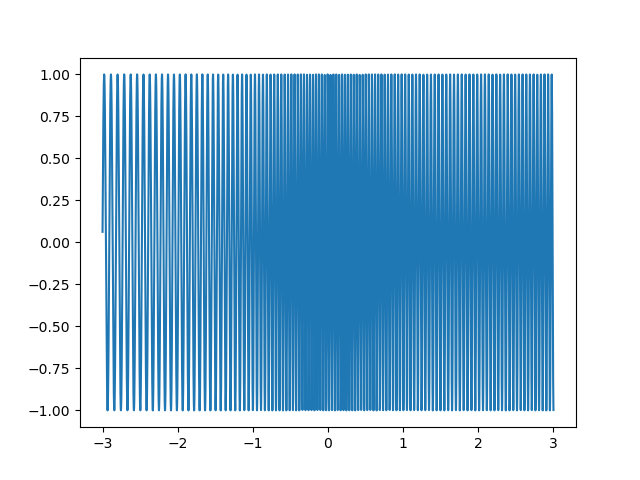

In [91]:
%matplotlib widget
plt.plot(time,signal)
plt.show()

500


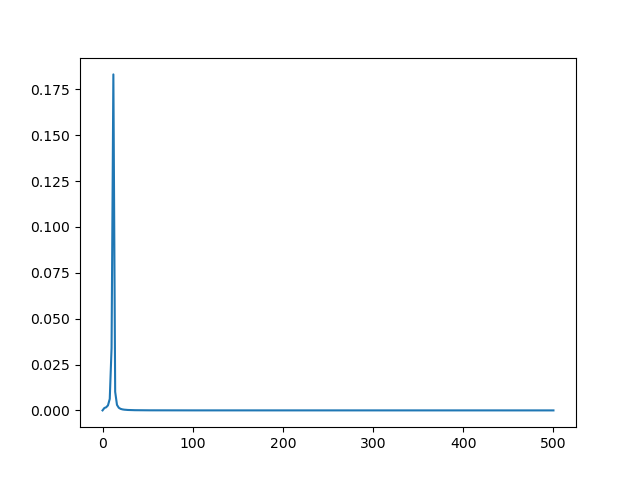

In [92]:
%matplotlib widget

window_size = int(srate/2)
print(window_size)
window = signal[:window_size]

spectrum = np.abs(scipy.fftpack.fft( window-np.mean(window) )/window_size)**2
hz = np.linspace(0, srate/2, int(np.floor(window_size/2)+1))

plt.plot(hz,spectrum[0:len(hz)])
plt.show()

In [103]:
window_size = int(srate/2)
print("window_size", window_size)
nb_windows = int(n/window_size)
print("nb windows", nb_windows)


hz = np.linspace(0, srate/2, int(np.floor(window_size/2)+1))
print("hz length", len(hz))

spectrogram = np.zeros((40, nb_windows ))

for i in range(0, nb_windows):
    window = signal[window_size*i : window_size*i+window_size]
    spectrum = np.abs(scipy.fftpack.fft( window)/window_size)**2
    spectrogram[:, i] = spectrum[0:40]

window_size 500
nb windows 12
hz length 251


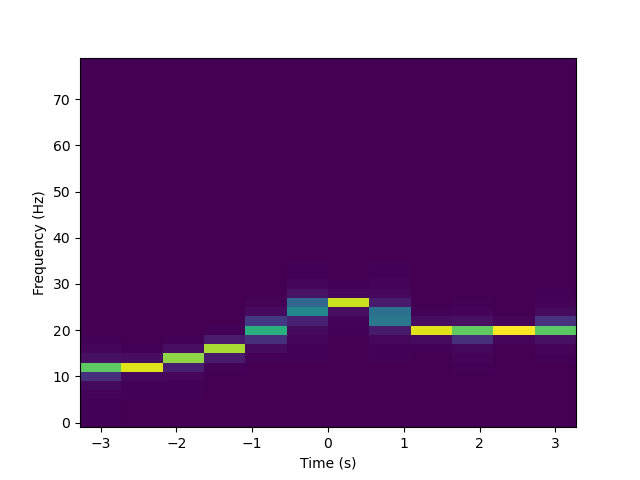

In [118]:
%matplotlib widget

plt.pcolormesh(np.linspace(-3,3,12), hz[:40],spectrogram)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.show()